<h1>MPII Pose Estimation</h1>

<h4>Modules</h4>

In [1]:
import scipy.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
import json

2024-07-20 01:07:19.468655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h4>Data Importing</h4>

First 5 image filenames: ['037454012.jpg', '095071431.jpg', '073199394.jpg', '059865848.jpg', '015601864.jpg']
Image path: ./images/037454012.jpg
[]
[(155, 430)]
First 5 image filenames: ['037454012.jpg', '095071431.jpg', '073199394.jpg', '059865848.jpg', '015601864.jpg']
Image path: ./images/092187424.jpg


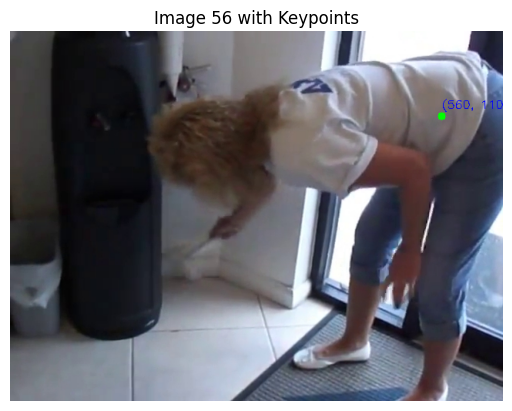

In [2]:
mat = scipy.io.loadmat('./mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')
data = mat['RELEASE']

# parse the annotations
annolist = data['annolist'][0, 0]

# extract image filenames
image_filenames = [annolist['image'][0, i]['name'][0, 0][0] for i in range(len(annolist['image'][0]))]
print(f"First 5 image filenames: {image_filenames[:5]}")

# prepare the list of complete image paths
images = ['./images/' + filename for filename in image_filenames]

# function to load an image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image at {image_path} not found.")
    return image

# function to parse keypoints
def parse_keypoints(keypoints):
    parsed_keypoints = []
    if 'annopoints' in keypoints.dtype.names:
        for person in keypoints['annopoints']:
            if person.size > 0 and 'point' in person[0].dtype.names:
                person_keypoints = person[0]['point'][0]
                for point in person_keypoints:
                    x = point['x'][0, 0] if 'x' in point.dtype.names else None
                    y = point['y'][0, 0] if 'y' in point.dtype.names else None
                    if x is not None and y is not None:
                        parsed_keypoints.append((x[0, 0], y[0, 0]))  # Extract single values from the arrays
    return parsed_keypoints

# extract keypoints for each image
keypoints = annolist['annorect'][0]

image_path = './images/' + image_filenames[0] 
print(f"Image path: {image_path}")
image = load_image(image_path)
person_keypoints = parse_keypoints(keypoints[0])
print(person_keypoints) 
image_index = 100 
if image_index < len(keypoints):
    person_keypoints = parse_keypoints(keypoints[image_index])
    print(person_keypoints)
else:
    print(f"No keypoints available for index {image_index}") # load the annotations file
mat = scipy.io.loadmat('./mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')
data = mat['RELEASE']

# parse the annotations
annolist = data['annolist'][0, 0]

# extract image filenames
image_filenames = [annolist['image'][0, i]['name'][0, 0][0] for i in range(len(annolist['image'][0]))]
print(f"First 5 image filenames: {image_filenames[:5]}")

# prepare the list of complete image paths
images = ['./images/' + filename for filename in image_filenames]

# function to load an image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image at {image_path} not found.")
    return image

# function to parse keypoints
def parse_keypoints(keypoints):
    parsed_keypoints = []
    if 'annopoints' in keypoints.dtype.names:
        for person in keypoints['annopoints']:
            if person.size > 0 and 'point' in person[0].dtype.names:
                person_keypoints = person[0]['point'][0]
                for point in person_keypoints:
                    x, y = point['x'][0, 0], point['y'][0, 0]
                    parsed_keypoints.append((x.item(), y.item()))
    return parsed_keypoints

# function to visualize keypoints on an image
def visualize_keypoints(image, keypoints, title="Image with Keypoints"):
    for x, y in keypoints:
        cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        cv2.putText(image, f"({int(x)}, {int(y)})", (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

index = 55  #
image_path = './images/' + image_filenames[index]
print(f"Image path: {image_path}")
image = load_image(image_path)
if image is not None:
    person_keypoints = parse_keypoints(annolist['annorect'][0][index])
    visualize_keypoints(image, person_keypoints, title=f"Image {index + 1} with Keypoints")

In [3]:
# create output directory if it doesn't exist
output_dir = './output_images/'
os.makedirs(output_dir, exist_ok=True)

# function to save visualized images
def save_keypoint_image(image, keypoints, filename, output_dir):
    for x, y in keypoints:
        cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        cv2.putText(image, f"({int(x)}, {int(y)})", (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, image)
    print(f"Saved keypoint image to {output_path}")

def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image at {image_path} not found.")
    return image
# function to load an image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image at {image_path} not found.")
    return image

# function to parse keypoints
def parse_keypoints(keypoints):
    parsed_keypoints = []
    if keypoints is not None and 'annopoints' in keypoints.dtype.names:
        for person in keypoints['annopoints']:
            if person.size > 0 and 'point' in person[0].dtype.names:
                person_keypoints = person[0]['point'][0]
                for point in person_keypoints:
                    if 'x' in point.dtype.names and 'y' in point.dtype.names:
                        x = point['x'][0, 0]
                        y = point['y'][0, 0]
                        parsed_keypoints.append((x.item(), y.item()))
    return parsed_keypoints

# function to visualize keypoints on an image
def visualize_keypoints(image, keypoints, filename, output_dir):
    for x, y in keypoints:
        cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        cv2.putText(image, f"({int(x)}, {int(y)})", (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    # save the annotated image
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, image)
    print(f"Saved annotated image to {output_path}")

# process and save keypoints for all images
for i in range(len(image_filenames)):
    image_path = './images/' + image_filenames[i]
    print(f"Processing image: {image_path}")
    image = load_image(image_path)
    if image is not None:
        try:
            keypoints = annolist['annorect'][0][i]
            if keypoints is None:
                print(f"No keypoints data available for image {image_filenames[i]}.")
                continue
            
            person_keypoints = parse_keypoints(keypoints)
            if person_keypoints:
                visualize_keypoints(image, person_keypoints, image_filenames[i], output_dir)
            else:
                print(f"No keypoints found for image {image_filenames[i]}.")
        except Exception as e:
            print(f"Error processing keypoints for image {image_filenames[i]}: {e}")
    else:
        print(f"Skipping image {image_filenames[i]} due to loading error.") # Variables to hold images and keypoints
images_with_keypoints = []
keypoints_data = {}
directory_path = './images/'
image_filenames = [f for f in os.listdir(directory_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# image files in the directory
image_files_in_directory = set(image_filenames)

# iterate over all images and save keypoints for images that have them
for i in range(len(image_filenames)):
    image_filename = image_filenames[i]
    if image_filename in image_files_in_directory:
        image_path = os.path.join(directory_path, image_filename)
        print(f"Processing image: {image_path}")
        image = load_image(image_path)
        if image is not None:
            try:
                keypoints = annolist['annorect'][0][i]
                if keypoints is None:
                    print(f"No keypoints data available for image {image_filename}.")
                    continue
                
                person_keypoints = parse_keypoints(keypoints)
                if person_keypoints:
                    images_with_keypoints.append(image_filename)
                    keypoints_data[image_filename] = person_keypoints
                else:
                    print(f"No keypoints found for image {image_filename}.")
            except Exception as e:
                print(f"Error processing keypoints for image {image_filename}: {e}")
        else:
            print(f"Skipping image {image_filename} due to loading error.")

# print or use the variables as needed
print(f"Images with keypoints: {images_with_keypoints}")
print(f"Keypoints data: {keypoints_data}")

#  save the keypoints data to a JSON file
output_keypoints_file = './keypoints_data.json'
with open(output_keypoints_file, 'w') as f:
    json.dump(keypoints_data, f)
print(f"Keypoints data saved to {output_keypoints_file}")

Processing image: ./images/037454012.jpg
No keypoints found for image 037454012.jpg.
Processing image: ./images/095071431.jpg
No keypoints found for image 095071431.jpg.
Processing image: ./images/073199394.jpg
No keypoints found for image 073199394.jpg.
Processing image: ./images/059865848.jpg
No keypoints found for image 059865848.jpg.
Processing image: ./images/015601864.jpg
Saved annotated image to ./output_images/015601864.jpg
Processing image: ./images/015599452.jpg
Saved annotated image to ./output_images/015599452.jpg
Processing image: ./images/005808361.jpg
Saved annotated image to ./output_images/005808361.jpg
Processing image: ./images/086617615.jpg
Saved annotated image to ./output_images/086617615.jpg
Processing image: ./images/060111501.jpg
Saved annotated image to ./output_images/060111501.jpg
Processing image: ./images/070807258.jpg
Saved annotated image to ./output_images/070807258.jpg
Processing image: ./images/002058449.jpg
Saved annotated image to ./output_images/00

[ WARN:0@19.274] global loadsave.cpp:241 findDecoder imread_('./images/040348287.jpg'): can't open/read file: check file path/integrity
[ WARN:0@19.274] global loadsave.cpp:241 findDecoder imread_('./images/013401523.jpg'): can't open/read file: check file path/integrity
[ WARN:0@19.275] global loadsave.cpp:241 findDecoder imread_('./images/002878268.jpg'): can't open/read file: check file path/integrity


No keypoints found for image 092658763.jpg.
Processing image: ./images/049211629.jpg
No keypoints found for image 049211629.jpg.
Processing image: ./images/025824439.jpg
Saved annotated image to ./output_images/025824439.jpg
Processing image: ./images/045913576.jpg
Saved annotated image to ./output_images/045913576.jpg
Processing image: ./images/098003258.jpg
No keypoints found for image 098003258.jpg.
Processing image: ./images/049261809.jpg
No keypoints found for image 049261809.jpg.
Processing image: ./images/032875161.jpg
No keypoints found for image 032875161.jpg.
Processing image: ./images/063340085.jpg
No keypoints found for image 063340085.jpg.
Processing image: ./images/024014562.jpg
No keypoints found for image 024014562.jpg.
Processing image: ./images/007586333.jpg
Saved annotated image to ./output_images/007586333.jpg
Processing image: ./images/012887972.jpg
Error processing keypoints for image 012887972.jpg: argument of type 'NoneType' is not iterable
Processing image: ./i

<h4>Data Preparation</h4>

In [4]:
# create image paths and keypoints lists
image_paths = ['./images/' + filename for filename in images_with_keypoints]
keypoints_list = [keypoints_data[filename] for filename in images_with_keypoints]

# split data into training and validation sets
split_index = int(0.8 * len(image_paths))
train_image_paths = image_paths[:split_index]
val_image_paths = image_paths[split_index:]
train_keypoints = keypoints_list[:split_index]
val_keypoints = keypoints_list[split_index:]

# debugging statements to check lengths
print(f"Length of train_image_paths: {len(train_image_paths)}")
print(f"Length of train_keypoints: {len(train_keypoints)}")
print(f"Length of val_image_paths: {len(val_image_paths)}")
print(f"Length of val_keypoints: {len(val_keypoints)}")

# check if any of the lists are empty
if len(train_image_paths) == 0 or len(train_keypoints) == 0 or len(val_image_paths) == 0 or len(val_keypoints) == 0:
    raise ValueError("One of the lists (train or validation) is empty. Please check your data splitting.") # Paths and keypoints
image_paths = ['./images/' + filename for filename in images_with_keypoints]
keypoints_list = [keypoints_data[filename] for filename in images_with_keypoints]


Length of train_image_paths: 13896
Length of train_keypoints: 13896
Length of val_image_paths: 3475
Length of val_keypoints: 3475


In [5]:
def load_images(image_paths, target_size):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  
        img_array = img_to_array(img)  
        img_array = img_array / 255.0  
        images.append(img_array)
    return np.array(images)

# define target image size
target_size = (128, 128)  
train_images = load_images(train_image_paths, target_size)
val_images = load_images(val_image_paths, target_size)

In [6]:
def normalize_keypoints(keypoints, image_size):
    normalized_keypoints = []
    for kp in keypoints:
        normalized_kp = [(x / image_size[1], y / image_size[0]) for x, y in kp]
        normalized_keypoints.append(normalized_kp)
    return np.array(normalized_keypoints)

# normalize keypoints
train_keypoints = normalize_keypoints(train_keypoints, target_size)
val_keypoints = normalize_keypoints(val_keypoints, target_size)

In [22]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

<h4>Model training</h4>

In [23]:
def create_model(input_shape, num_keypoints, learning_rate):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(num_keypoints * 2, kernel_regularizer=regularizers.l2(0.01)))  # Each keypoint has (x, y) coordinates
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# define constants
input_shape = (target_size[0], target_size[1], 3)
num_keypoints = len(train_keypoints[0]) 

# create the model
model = create_model(input_shape, num_keypoints, learning_rate=0.001)


/home/marius/Desktop/Coding/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
datagen.fit(train_images)

In [25]:
# define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train the model with data augmentation and learning rate scheduling
history = model.fit(datagen.flow(train_images, train_keypoints),
                                        epochs=10,
                                        validation_data=(val_images, val_keypoints),
                                        callbacks=[reduce_lr, early_stopping])

Epoch 1/10


/home/marius/Desktop/Coding/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


435/435 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - loss: 28.0091 - mean_squared_error: 14.2785 - val_loss: 10.4981 - val_mean_squared_error: 4.7851 - learning_rate: 0.0010
Epoch 2/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - loss: 9.7860 - mean_squared_error: 5.1204 - val_loss: 7.3676 - val_mean_squared_error: 4.7983 - learning_rate: 0.0010
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - loss: 6.8693 - mean_squared_error: 4.7185 - val_loss: 6.3620 - val_mean_squared_error: 5.0599 - learning_rate: 0.0010
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - loss: 5.7125 - mean_squared_error: 4.5983 - val_loss: 5.2833 - val_mean_squared_error: 4.5774 - learning_rate: 0.0010
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - loss: 5.2055 - mean_squared_error: 4.6067 - val_loss: 4.9902 - val_mean_squared_error: 4.6013 - learning_rate: 0.0010
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - loss: 4.8699 - mean_squared_error: 4.5189 - val_loss: 4.9637 - val_mean_squared_er

<h4>Model evaluation </h4>

In [28]:
# evaluate the model
val_loss = model.evaluate(val_images, val_keypoints)
print(f'Validation Loss: {val_loss}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7256 - mean_squared_error: 4.6413
Validation Loss: [4.612731456756592, 4.528344631195068]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


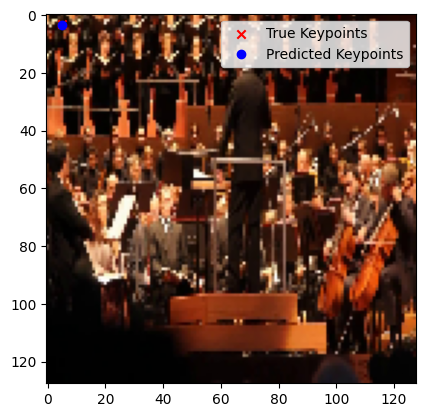

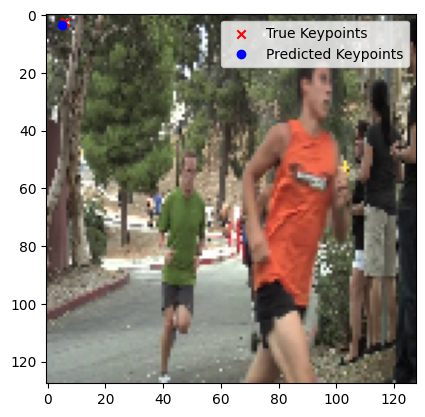

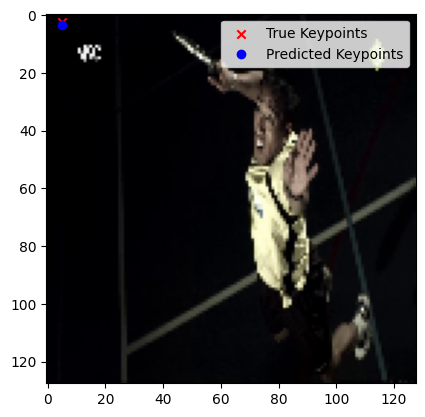

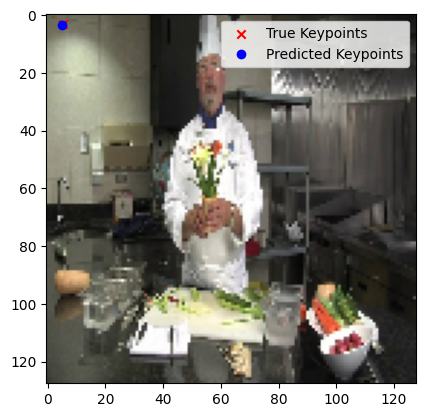

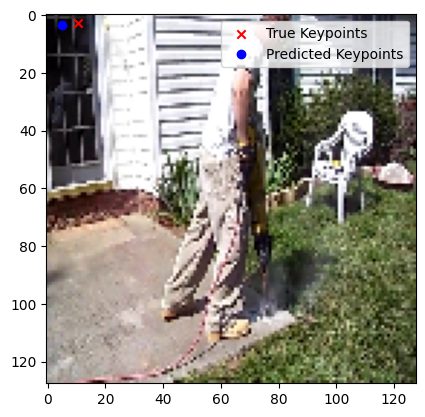

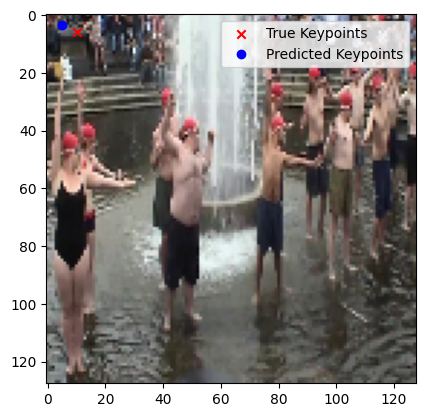

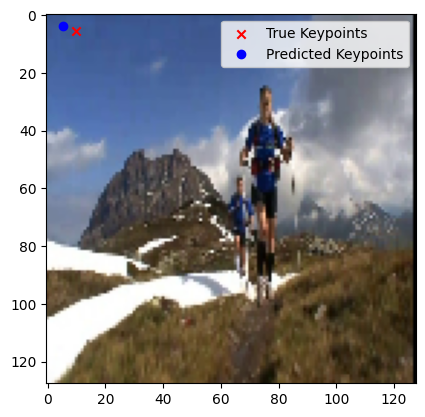

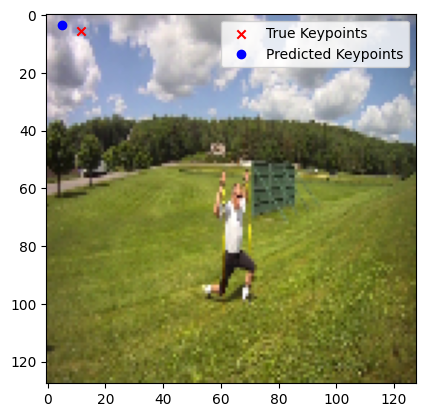

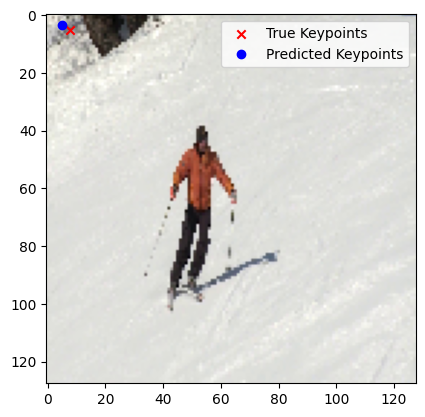

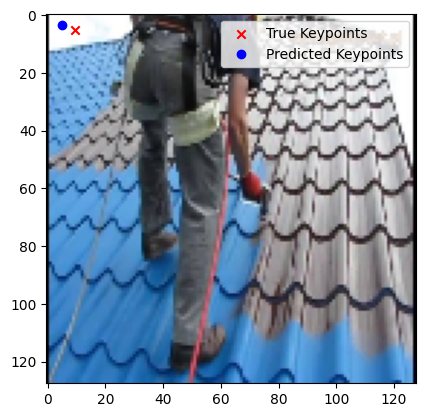

In [27]:
val_images_batch = val_images[:10]
val_keypoints_batch = val_keypoints[:10]

# make predictions
predicted_keypoints = model.predict(val_images_batch)

# plot images with predicted keypoints
def plot_keypoints(image, keypoints, predicted_keypoints=None):
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x', label='True Keypoints')
    if predicted_keypoints is not None:
        plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='b', marker='o', label='Predicted Keypoints')
    plt.legend()
    plt.show()

# plot some validation images with true and predicted keypoints
for i in range(len(val_images_batch)):
    image = val_images_batch[i]
    true_keypoints = val_keypoints_batch[i].reshape(-1, 2)
    pred_keypoints = predicted_keypoints[i].reshape(-1, 2)
    plot_keypoints(image, true_keypoints, pred_keypoints)